<a href="https://colab.research.google.com/github/ZYY799/LLM-Repo-Collection/blob/main/TTS_302_share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-to-Speech Tutorial with `gemini-2.5-flash-preview-tts`

In [ ]:
import requests
import wave
import time
import os
import re
import json
import base64
from pydub import AudioSegment
import shutil
import glob

## **Retrieve API Key from Google Colab**

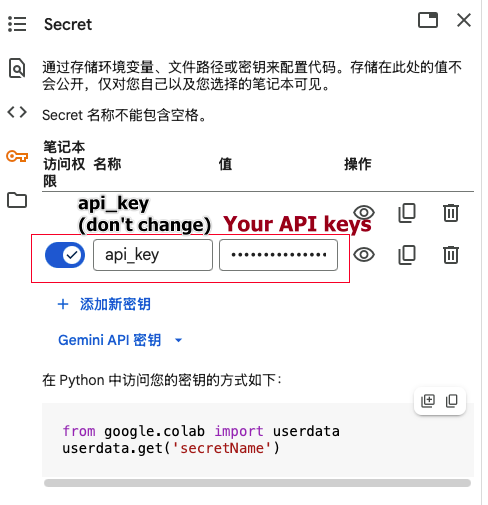

You can directly use the API provided by Google AI Studio, but I cannot use it (due to bank card/region restrictions), so I use a **proxy service**:
- https://302.ai/dashboard/overview

In [ ]:
from google.colab import userdata
api_key = userdata.get('api_key')

## **Define 302.ai Client Class**

- Define Configuration Classes
- Initialize API Client


In [ ]:
class Client302AI:
    def __init__(self, api_key):
        self.api_key = api_key
        self.models = self

    def generate_content(self, model, contents, config):
        url = "https://api.302.ai/google/v1/models/gemini-2.5-flash-preview-tts"

        headers = {
            'Authorization': f'Bearer {self.api_key}',
            'Content-Type': 'application/json'
        }

        payload = {
            "contents": [
                {
                    "parts": [
                        {
                            "text": contents
                        }
                    ]
                }
            ],
            "generationConfig": {
                "responseModalities": config.response_modalities,
                "speechConfig": {
                    "voiceConfig": {
                        "prebuiltVoiceConfig": {
                            "voiceName": config.speech_config.voice_config.prebuilt_voice_config.voice_name
                        }
                    }
                }
            },
            "model": "gemini-2.5-flash-preview-tts"
        }

        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()

        result = response.json()

        class MockResponse:
            def __init__(self, data):
                self.candidates = [MockCandidate(data)]

        class MockCandidate:
            def __init__(self, data):
                self.content = MockContent(data)

        class MockContent:
            def __init__(self, data):
                self.parts = [MockPart(data)]

        class MockPart:
            def __init__(self, data):
                if 'candidates' in data and len(data['candidates']) > 0:
                    candidate = data['candidates'][0]
                    if 'content' in candidate and 'parts' in candidate['content']:
                        for part in candidate['content']['parts']:
                            if 'inlineData' in part and 'data' in part['inlineData']:
                                self.inline_data = MockInlineData(part['inlineData']['data'])
                                break

        class MockInlineData:
            def __init__(self, data):
                self.data = base64.b64decode(data)

        return MockResponse(result)

In [ ]:
class types:
    class GenerateContentConfig:
        def __init__(self, response_modalities, speech_config):
            self.response_modalities = response_modalities
            self.speech_config = speech_config

    class SpeechConfig:
        def __init__(self, voice_config):
            self.voice_config = voice_config

    class VoiceConfig:
        def __init__(self, prebuilt_voice_config):
            self.prebuilt_voice_config = prebuilt_voice_config

    class PrebuiltVoiceConfig:
        def __init__(self, voice_name):
            self.voice_name = voice_name

In [ ]:
client = Client302AI(api_key = api_key)

### **Audio Saving Function**

In [ ]:
def save_audio(filename, audio_data, channels=1, rate=24000, sample_width=2):
    with wave.open(filename, "wb") as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(sample_width)
        wf.setframerate(rate)
        wf.writeframes(audio_data)
    print(f"succed: {filename}")

## **Source Text Content process**

In [ ]:
text = """
### 1. Do you love flowers?

Yes, absolutely! But I think I'm more attracted to what flowers symbolize rather than just their appearance. For instance, roses represent love and romance, which I find really meaningful. There's something special about the emotions and messages that different flowers can convey.

### 2. Do you know anyone who loves flowers?

Hmm, that's a good question. I wouldn't say people directly tell me "I love flowers," but I can see it in their actions. Like my mum - she's always taking photos of beautiful flowers and using them as her phone wallpaper or sharing them on social media. I think many people appreciate flowers even if they don't explicitly say so.

### 3. Are there a lot of flowers where you live?

To be honest, I haven't really paid much attention to this because I'm usually so busy with work and studies. But now that you mention it, I think there are flowers pretty much everywhere around there. I do remember our campus has some beautiful cherry blossoms that bloom in spring - they're quite impressive.

### 4. Do you take photos of flowers in you daily life?

Yes, I do sometimes. I like to capture them when they're in full bloom and looking their best. I also use flowers as backgrounds when taking photos of people I care about - I think it could make the photos more beautiful and meaningful.

### 5. Do people in your country often send flowers to others?

Yes, definitely! It's quite common, especially for special occasions like birthdays or holidays. People often send flowers to express their feelings - like roses for love or flowers to teachers on Teacher's Day.
"""

 ## **Parse Text for Dialogue Format**(optional)

In [ ]:
pairs = re.findall(r"### \d+\.\s*(.*?)\n\n(.*?)(?=\n###|\Z)", text, re.S)

dialogue_list = []
for q, a in pairs:
    dialogue_list.append(q.strip())
    dialogue_list.append(a.strip())

Display Parsed Dialogue List

In [ ]:
dialogue_list

['Do you love flowers?',
 "Yes, absolutely! But I think I'm more attracted to what flowers symbolize rather than just their appearance. For instance, roses represent love and romance, which I find really meaningful. There's something special about the emotions and messages that different flowers can convey.",
 'Do you know anyone who loves flowers?',
 'Hmm, that\'s a good question. I wouldn\'t say people directly tell me "I love flowers," but I can see it in their actions. Like my mum - she\'s always taking photos of beautiful flowers and using them as her phone wallpaper or sharing them on social media. I think many people appreciate flowers even if they don\'t explicitly say so.',
 'Are there a lot of flowers where you live?',
 "To be honest, I haven't really paid much attention to this because I'm usually so busy with work and studies. But now that you mention it, I think there are flowers pretty much everywhere around there. I do remember our campus has some beautiful cherry blosso

## Configure Voice Settings

In [ ]:
voices = ["Zephyr", "Leda"]
print(f"{len(dialogue_list)} segments will be generated")

10 segments will be generated


## **Audio Generation & Merging Function**

In [ ]:
def generate_audio(text, voice_name, retry_delay=10):
    for attempt in range(3):
        try:
            response = client.models.generate_content(
                model="gemini-2.5-flash-preview-tts",
                contents=text,
                config=types.GenerateContentConfig(
                    response_modalities=["AUDIO"],
                    speech_config=types.SpeechConfig(
                        voice_config=types.VoiceConfig(
                            prebuilt_voice_config=types.PrebuiltVoiceConfig(
                                voice_name=voice_name
                            )
                        )
                    )
                )
            )
            audio_data = response.candidates[0].content.parts[0].inline_data.data
            return audio_data

        except Exception as e:
            print(f"{attempt+1} error: {e}")
            if attempt < 2:
                print(f"after{retry_delay}seconds...retry")
                time.sleep(retry_delay)
                retry_delay *= 1
            else:
                print("Error")
                return None

In [ ]:
def merge_audio_files(audio_files):
    print("\n merging...")

    combined = AudioSegment.empty()

    for i, filename in enumerate(audio_files):
        try:
            audio = AudioSegment.from_wav(filename)
            combined += audio

            if i % 2 == 0:
                combined += AudioSegment.silent(duration=500)
            else:
                combined += AudioSegment.silent(duration=1000)

        except Exception as e:
            print(f"{filename} merge error:{e}")
    file_name = input("name for what: ")
    name = file_name.strip()
    output_file = f"{name}.wav"
    combined.export(output_file, format="wav")

    duration = len(combined) / 1000
    print(f"\n Finished!")
    print(f"file: {output_file}")
    print(f"duration: {duration:.1f}sec")

In [ ]:
def main():
    print("start...")
    audio_files = []

    for i, text in enumerate(dialogue_list):
        is_question = (i % 2 == 0)
        voice_name = voices[0] if is_question else voices[1]
        speaker_type = "Question" if is_question else "Answer"
        filename = f"audio_{i+1:02d}_{speaker_type}_{voice_name}.wav"

        if os.path.exists(filename):
            print(f"escape: {filename}")
            audio_files.append(filename)
            continue

        print(f"\n generate{i+1}segment: ({speaker_type})")
        print(f"text: {text[:20]}...")

        audio_data = generate_audio(text, voice_name)

        if audio_data:
            save_audio(filename, audio_data)
            audio_files.append(filename)
        else:
            print(f"{i+1}seg error")
            break

        if i < len(dialogue_list) - 1:
            print("5s...")
            time.sleep(5)

    if len(audio_files) == len(dialogue_list):
        merge_audio_files(audio_files)
    else:
        print(f"only {len(audio_files)}/{len(dialogue_list)} was done")

Execute

In [ ]:
main()

**File Management and Organization**

In [ ]:
base_path = "/content/drive/MyDrive/Google AI Studio"
folder_name = input("root name for: ")
target_folder = os.path.join(base_path, folder_name)
os.makedirs(target_folder, exist_ok=True)

audio_files = glob.glob("*.wav")

moved_count = 0
for file in audio_files:
    if os.path.exists(file):
        try:
            shutil.move(file, os.path.join(target_folder, file))
            print(f"Moved: {file}")
            moved_count += 1
        except Exception as e:
            print(f"Failed to move {file}: {e}")

print(f"\nComplete! Moved {moved_count} files to:")
print(f"{target_folder}")

print(f"\nFolder contents:")
for file in os.listdir(target_folder):
    print(f"  - {file}")

## **Single Audio Generation**
Identical to the above

In [ ]:
def generate_single_audio(text, voice_name="Zephyr", output_filename="output.wav", api_key=None):

    print(f"start...")
    print(f"text: {text[:50]}{'...' if len(text) > 50 else ''}")
    print(f"voice: {voice_name}")

    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash-preview-tts",
            contents=text,
            config=types.GenerateContentConfig(
                response_modalities=["AUDIO"],
                speech_config=types.SpeechConfig(
                    voice_config=types.VoiceConfig(
                        prebuilt_voice_config=types.PrebuiltVoiceConfig(
                            voice_name=voice_name
                        )
                    )
                )
            )
        )

        audio_data = response.candidates[0].content.parts[0].inline_data.data

        save_audio(output_filename, audio_data)

        return True

    except Exception as e:
        print(f"{e}")
        return False

In [ ]:
single_text = """
Well, I'd like to talk about this content creator I follow called Bidao. He's actually a PhD student from Tsinghua University, and he's become quite famous for his science education videos.

I first discovered him about two years ago when I was browsing Bilibili late at night. You know how the algorithm sometimes recommends random videos? Well, I came across this video with a really eye-catching title - something like "How to scientifically get a boyfriend." I mean, the title was so bizarre that I just had to click on it, right?

And what I saw was absolutely mind-blowing. This guy, who's clearly super smart with his PhD background, was using actual scientific methods and data analysis to tackle what most people would consider just relationship advice. He approached it with graphs, statistics, probability calculations - the whole nine yards. His video editing was really professional too, and he has this dry, humorous way of presenting things that just makes everything so entertaining.

What really **influenced** me about Bidao is his approach to problem-solving. He's shown me that you can apply scientific thinking to literally anything in daily life. Before watching his content, I used to just wing it. But now I've started thinking more systematically about problems.

**His videos have changed how I view learning** and proved that education doesn't have to be boring. This has actually motivated me to be more curious about subjects I used to find dull, like statistics or research methods. I guess you could say he's made me more scientifically minded in my daily life."""

In [ ]:
name = input("name for what: ")
success = generate_single_audio(
    text=single_text,
    voice_name="Zephyr",
    output_filename=f"{name}.wav",
    api_key=api_key
)

if success:
    print("complete!")
else:
    print("error?")

In [ ]:
base_path = "/content/drive/MyDrive/Google AI Studio"
folder_name = input("New folder name: ")
target_folder = os.path.join(base_path, folder_name)
os.makedirs(target_folder, exist_ok=True)
print(f"Created folder: {target_folder}")

audio_files = glob.glob("*.wav")

moved_count = 0
for file in audio_files:
    if os.path.exists(file):
        try:
            shutil.move(file, os.path.join(target_folder, file))
            print(f"Moved: {file}")
            moved_count += 1
        except Exception as e:
            print(f"Failed to move {file}: {e}")

print(f"\nComplete! Moved {moved_count} files to:")
print(f"{target_folder}")

print(f"\nFolder contents:")
for file in os.listdir(target_folder):
    print(f"  - {file}")